# FGSM by torchattacks

## Preprocessing

### Load pretraiend model resnet56 from torch.hub

In [1]:
import torch
# Here is the selection: Loading from Github or local source.
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)
#model = torch.hub.load("./pytorch-cifar-models", "cifar10_resnet56", pretrained=True,source='local')

/Users/liufazhong/opt/anaconda3/envs/pytor/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /Users/liufazhong/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


### Load dataset from CIFAR-10

In [2]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchattacks
from torchvision.utils import save_image
import os

In [3]:
use_cuda = True

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     transforms.Normalize(norm_mean, norm_std),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

org_img = []
org_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        org_img.append(images)
        org_labels.append(labels)


Files already downloaded and verified
Files already downloaded and verified


### Test accuracy of the model

In [4]:
# definition of const

# Small test
st = 100
# Midium test
mt = 400
# Large test
lt = 1000
# Full test
ft = 2500

In [5]:
def test_acc_new(model, testloader, test_images, n_image = 100, save_test_images = False):
    correct = 0
    total = 0
    p_labels = []
    saved_img = []
    i = 0
    for data in testloader:
        images, labels = data
        if total < n_image:
            outputs = model(test_images[i])
            _, predicted = torch.max(outputs.data, 1)
            for j in labels:
                if save_test_images and total % 4 == 0:
                    saved_img.append(test_images[total])
#                 print(predicted, j)

                p_labels.append(predicted)
                if predicted[total%4] == j:
                    correct += 1
                total += 1
            # if total % 40 == 0:
            #     print("Iterations:{} / {} \n Test Accuracy = {} / {} = {}".format(total, n_image,  correct, total, str(correct / total)[:4]))
            i += 1
        else:
            break
    test_accuracy = (100.0 * correct / total)
    print('Accuracy of the network on the', total, "images is: ", test_accuracy, '%')
    print("Saving test images = ", save_test_images)
    if save_test_images == True:
        return test_accuracy, p_labels, saved_img
    else:
        return test_accuracy, p_labels

In [6]:
test_accuracy, resnet56_labels, orig = test_acc_new(model, testloader, org_img, mt, True)

Accuracy of the network on the 400 images is:  74.25 %
Saving test images =  True


In [7]:
# save_image(org_img[0],'img_try/ori_img.png')

## FGSM attack

### Tool functions

In [8]:
# def unnormalize(img, mean = np.array(norm_mean), std = np.array(norm_std)):
#     '''
#     unnormalize the image that has been normalized with mean and std
#     '''
#     inverse_mean = - mean/std
#     inverse_std = 1/std
#     img = transforms.Normalize(mean=-mean/std, std=1/std)(img)
#     return img

# def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))

# def ax_imshow(ax, img, label):
#     img = unnormalize(img)     # unnormalize
#     img = np.clip(img, 0., 1.)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     img = np.transpose(img, (1,2,0))
#     ax.imshow(img)
#     ax.set_title(classes[label])

### Implement torchattacks.FGSM

In [9]:
test_loader_1=torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)
epsilons = []
init_eps = 0
accuracies=[]
step = 0.001
n_step = 5

# for i in range(n_step):
#     epsilons.append(init_eps + i*step)


# Run test for each epsilon


In [10]:
# epsilons=[0.001,0.005,0.01,0.05,0.1,0.5,1]
epsilons=[0]

In [11]:
print(epsilons)

[0]


In [12]:
def unnormalize(img, mean = np.array(norm_mean), std = np.array(norm_std)):
    '''
    unnormalize the image that has been normalized with mean and std
    '''
    inverse_mean = - mean/std
    inverse_std = 1/std
    img = transforms.Normalize(mean=-mean/std, std=1/std)(img)
    return img

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def ax_imshow(ax, img, label):
    img = unnormalize(img)     # unnormalize
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])

In [13]:
eps_times=0
fin_image=[]
fgsm_examples = []
for eps in epsilons:
    visual_examples = 5
    fgsm_img = []
    attack = torchattacks.FGSM(model, eps)
    count = 0
    for i in range(500):
        fgsm_img.append(attack(org_img[i], org_labels[i]))
    fgsm_test_accuracy, fgsm_labels , a_images= test_acc_new(model, testloader, fgsm_img, mt, True)
    dataiter = iter(testloader)
    images, labels = dataiter.next()

# print images
    #imshow(torchvision.utils.make_grid(a_images[0]))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
    accuracies.append(fgsm_test_accuracy)
    fgsm_examples.append(a_images)

Accuracy of the network on the 400 images is:  57.75 %
Saving test images =  True
GroundTruth:    cat  ship  ship plane


In [14]:
print(len(a_images))

100


In [15]:
print(accuracies)

[57.75]


ZeroDivisionError: float division by zero

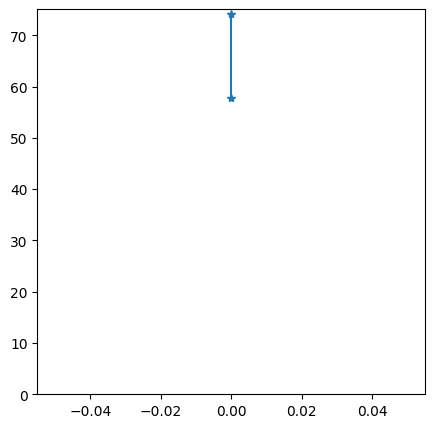

In [16]:
plt.figure(figsize=(5,5))
plt.plot([0] + epsilons, [test_accuracy] + accuracies, "*-")
plt.yticks(np.arange(0.0, test_accuracy, step=10))
plt.xticks(np.arange(0.0, max(epsilons), step=max(epsilons)/5))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [17]:
os.getcwd()

'/Users/liufazhong/Documents/GitHub/pyt_adv'

图片导出

In [ ]:
time=0;
for i in range(len(fgsm_examples)):
    dir_name=os.getcwd()+'/FGSM_img/_%i/'%(i,)
    os.mkdir(dir_name)

    id=0
    for j in range(len(fgsm_examples[i])):
        save_image(fgsm_examples[i][j],dir_name+'%i.png'%(time,))
        time+=1


GroundTruth:    cat  ship  ship plane


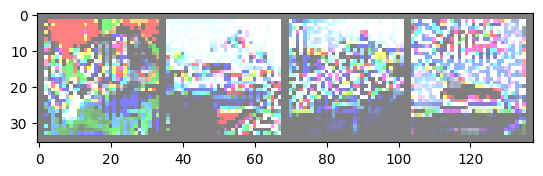

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(a_images[0]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

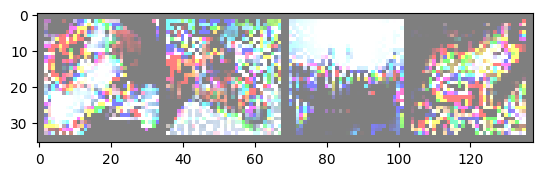

In [ ]:
imshow(torchvision.utils.make_grid(fgsm_examples[6][1]))

In [ ]:
save_image(fgsm_examples[6][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


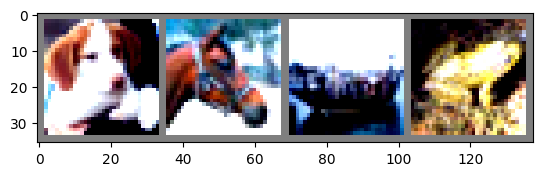

In [ ]:
imshow(torchvision.utils.make_grid(orig[1]))